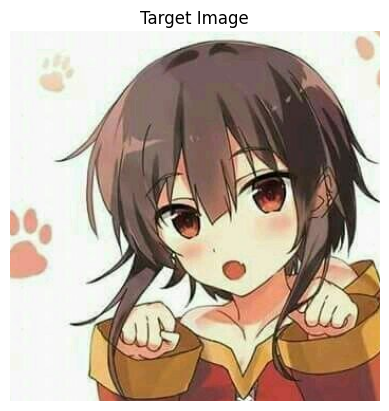

1) find an optimal solution among all available filaments
1.1) find a "good" filament order
1.2) convert the mixes into blended layers
1.3) reconstruct blended image


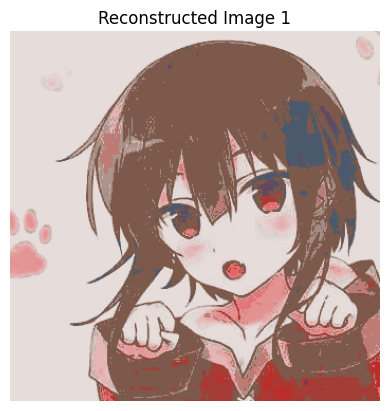

2) get rid of as many filaments as posible (without compromising the quality)
3) find a solution among the reduced set of filaments
4) convert the mixes into blended layers
5) reconstruct blended image


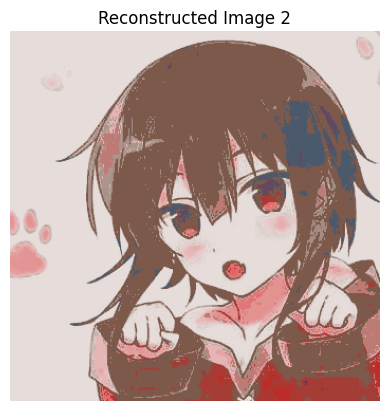

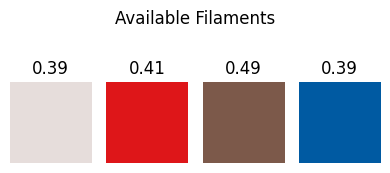

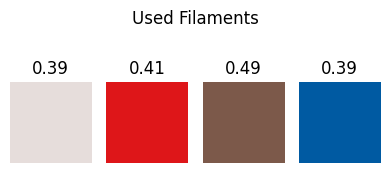

In [ ]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from PIL import Image
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull

# --- UTILITY FUNCTIONS ---
def map_local_to_global_indices(local_indices: list[int], global_indices: list[int]):
    return [global_indices[i] for i in local_indices]

def clamp(val, lb, ub):
    return min(max(lb, val), ub)

def rgb_to_lab(rgb):
    rgb = np.array(rgb).reshape(1, 1, 3)
    lab = color.rgb2lab(rgb)
    return lab[0, 0]

def lab_to_rgb(lab):
    lab = np.array(lab).reshape(1, 1, 3)
    rgb = color.lab2rgb(lab)
    return rgb[0, 0]

def alpha_from_td(thickness, td):
    """
    Convert thickness (mm) and transmission distance (mm) to an opacity:
      alpha = 1 - exp(-thickness / td)
    """
    return 1 - np.exp(-thickness / td)

def color_distance(rgb1, rgb2):
    rgb1 = np.array(rgb1).reshape(1, 1, 3)
    rgb2 = np.array(rgb2).reshape(1, 1, 3)
    lab1 = color.rgb2lab(rgb1)
    lab2 = color.rgb2lab(rgb2)

    # Euclidean distance in LAB space
    return np.linalg.norm(lab1 - lab2)

def mix_colors(colors: list[list[float]], coords: list[float]):
    mixed_rgb = np.array([0.0, 0.0, 0.0])
    for i in range(len(coords)):
        mixed_rgb += coords[i] * colors[i]

    return mixed_rgb

def blend_layers(layers: list[int], colors):
    current_rgb = np.array([0.0, 0.0, 0.0], dtype=float)
    current_alpha = 0.0

    for c_index in layers:
        rgb = np.array(colors[c_index]['rgb'], dtype=float)
        alpha = float(colors[c_index]['alpha'])

        current_rgb = rgb * alpha + current_rgb * (1 - alpha)
        current_alpha = alpha + current_alpha * (1 - alpha)
    
    return (current_rgb / current_alpha, current_alpha)

# --- SETTINGS ---

filaments = {
    'Cotton White': {
        'rgb': [0.9019607843137255, 0.8666666666666667, 0.8588235294117647],
        'td': 0.41,   # Transmission Distance in mm
    },
    'Lava Red': {
        'rgb': [0.8705882352941177, 0.08627450980392157, 0.09803921568627451],
        'td': 0.38,
    },
    'Earth Brown': {
        'rgb': [0.48627450980392156, 0.34901960784313724, 0.2901960784313726],
        'td': 0.3,
    },
    'Sapphire Blue': {
        'rgb': [0.0, 0.35294117647058826, 0.6352941176470588],
        'td': 0.4,
    },
}

layer_thickness = 0.2  # mm per layer
target_image = Image.open('./input/target_350.png').convert('RGB')

# --- SETUP ---
#                   vertex_index[], coords[]
type VertexMix = tuple[list[int], list[float]]

img_arr = np.asarray(target_image) / 255.0  # Normalize to [0, 1]
img_height, img_width, _ = img_arr.shape
target_colors = img_arr.reshape(-1, 3)

color_mixes: list[VertexMix] = [None] * len(target_colors)
color_layers: list[list[int]] = [None] * len(target_colors)
blended_colors = np.zeros((len(target_colors), 3), dtype=np.float32)

colors = [] # {"rgb", "alpha"}[]
point_list = [] # [rgb][]
for f_name, f in filaments.items():
    rgb = np.array(f['rgb'])
    td = f['td']
    alpha = alpha_from_td(layer_thickness, td)
    colors.append({
        "key": f_name,
        "rgb": rgb,
        "alpha": alpha
    })
    point_list.append(rgb)
colors = np.array(colors)
points = np.array(point_list)

# --- PLOT FUNCTIONS ---

def print_image(img: Image, title: str):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def print_comparasion(target_color, rgb1, rgb2):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4, 2))
    dist1 = round(color_distance(rgb1, target_color), 2)
    ax1.imshow(np.ones((10,10,3)) * rgb1.reshape((1,1,3)))
    ax1.set_title(f"mixed dist: {dist1}")

    ax2.imshow(np.ones((10,10,3)) * np.array(target_color).reshape((1,1,3)))
    ax2.set_title("Target")
    
    dist2 = round(color_distance(rgb2, target_color), 2)
    ax3.imshow(np.ones((10,10,3)) * rgb2.reshape((1,1,3)))
    ax3.set_title(f"blended dist: {dist2}")

    for ax in (ax1, ax2, ax3):
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def print_filaments():
    fig, axes = plt.subplots(1, len(colors), figsize=(4, 2))

    for i, ax in enumerate(axes):
        col = colors[i]
        ax.imshow(np.ones((10,10,3)) * col['rgb'].reshape((1,1,3)))
        ax.set_title(f"{round(col['alpha'], 2)}")
        ax.axis('off')

    fig.suptitle("Available Filaments")
    plt.tight_layout()
    plt.show()

def print_colors(color_indices: list[int]):
    fig, axes = plt.subplots(1, len(color_indices), figsize=(4, 2))

    for i, ax in enumerate(axes):
        col = colors[color_indices[i]]
        ax.imshow(np.ones((10,10,3)) * col['rgb'].reshape((1,1,3)))
        ax.set_title(f"{round(col['alpha'], 2)}")
        ax.axis('off')

    fig.suptitle("Used Filaments")
    plt.tight_layout()
    plt.show()


def log_color_names(ids):
    for index in ids:
        print(colors[index]['key'])

def print_result():
    for i, col_mix in enumerate(color_mixes):
        target_color = target_colors[i]
        layers = color_layers[i]

        # mix filament colors to get mixed_rgb
        color_indexes = col_mix[0]
        coords = col_mix[1]
        base_colors = points[color_indexes]
        mixed_rgb = mix_colors(base_colors, coords)

        # blend filament
        blended_rgb, blended_alpha = blend_layers(layers, colors)
        
        print_comparasion(target_color, mixed_rgb, blended_rgb)

# --- FUNCTIONS --- 

def barycentric_2d_lab(A: np.ndarray, B: np.ndarray, C: np.ndarray, X: np.ndarray) -> tuple[float, float, float]:
    # Precompute LAB(X) once:
    lab_X = rgb_to_lab(X)

    # Objective: given (u, v), w = 1 - u - v
    def lab_dist_uv(u, v):
        w = 1.0 - u - v
        if u < 0 or v < 0 or w < 0:
            return np.inf
        M_rgb = u * A + v * B + w * C
        lab_M = rgb_to_lab(M_rgb)
        return np.linalg.norm(lab_M - lab_X)

    # Initial guess
    u, v, w = barycentric_2d(A, B, C, X)
    # clamp to [0,1] then renormalize so sum=1
    u, v, w = np.clip([u, v, w], 0.0, 1.0)
    s = u + v + w
    u, v, w = u / s, v / s, w / s
    
    best_dist = lab_dist_uv(u, v)
    k = 0.1

    for _ in range(100):
        if k < 1e-4:
            break

        improved = False
        # Try adjustments: (u±k, v) and (u, v±k)
        for du, dv in [(k, 0), (-k, 0), (0, k), (0, -k)]:
            u_new = u + du
            v_new = v + dv
            d_new = lab_dist_uv(u_new, v_new)
            if d_new < best_dist:
                u, v = u_new, v_new
                best_dist = d_new
                improved = True
                break  # accept first improving move

        if not improved:
            k /= 2.0

    w = 1.0 - u - v
    return u, v, w

def barycentric_1d(A: np.ndarray, B: np.ndarray, X: np.ndarray) -> float:
    """
    Computes the 1D barycentric coordinates u, v of point X on the line AB,
    such that X ≈ u * A + v * B.
    """
    AB = B - A
    denom = np.dot(AB, AB)
    if denom == 0:
        return 0.0  # A and B are the same point
    v = np.dot(X - A, AB) / denom
    u = 1.0 - v
    return u, v

def barycentric_2d(A: np.ndarray, B: np.ndarray, C: np.ndarray, X: np.ndarray) -> tuple[float, float, float]:
    """
    Computes the 2D barycentric coordinates (u, v, w) of point X with respect to triangle ABC,
    such that X ≈ u * A + v * B + w * C and u + v + w = 1.
    """
    v0 = B - A
    v1 = C - A
    v2 = X - A

    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    d20 = np.dot(v2, v0)
    d21 = np.dot(v2, v1)

    denom = d00 * d11 - d01 * d01
    if denom == 0:
        return (1.0, 0.0, 0.0)  # Degenerate triangle

    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w
    return (u, v, w)

def barycentric_3d(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, X: np.ndarray) -> tuple[float, float, float, float]:
    """
    Computes 3D barycentric coordinates (u, v, w, t) of point X with respect to tetrahedron ABCD,
    such that X ≈ u*A + v*B + w*C + t*D and u + v + w + t = 1.
    """
    # Matrix of vectors relative to A
    M = np.column_stack((B - A, C - A, D - A))  # 3x3 matrix
    Y = X - A  # Vector from A to X

    try:
        coords = np.linalg.solve(M, Y)
        v, w, t = coords
        u = 1.0 - v - w - t
        return (u, v, w, t)
    except np.linalg.LinAlgError:
        # Degenerate tetrahedron (volume = 0)
        return (1.0, 0.0, 0.0, 0.0)
    
def barycentric_nd(points: list[np.ndarray], X: np.ndarray) -> list[float]:
    """
    Computes barycentric coordinates of point X with respect to a simplex defined by `points`.
    
    Arguments:
    - points: list of n+1 points (np.ndarray of same dimension), defining an n-dimensional simplex
    - X: point (np.ndarray) for which to compute barycentric coordinates
    
    Returns:
    - list of barycentric coordinates [b0, b1, ..., bn] such that sum(bi) = 1
    """
    P0 = points[0]
    Vs = [P - P0 for P in points[1:]]  # Edge vectors from P0
    V = np.column_stack(Vs)  # d x n matrix
    Y = X - P0

    try:
        coeffs = np.linalg.lstsq(V, Y, rcond=None)[0]  # solve V @ coeffs = Y
        bary_coords = [1.0 - np.sum(coeffs)] + list(coeffs)
        return bary_coords
    except np.linalg.LinAlgError:
        # Degenerate simplex (e.g., zero volume)
        return [1.0] + [0.0] * (len(points) - 1)

def find_containing_tetra(delaunay: Delaunay, X: np.ndarray):
    """
    Finds a Delaunay tetrahedron (by indices into S) that contains X, or returns None if X is outside Conv(S).
    S = array of points
    X = target point
    """
    X = np.asarray(X)

    simplex_index = delaunay.find_simplex(X)
    if simplex_index < 0:
        return None                      # X is outside Conv(S)

    tet_idx = tuple(delaunay.simplices[simplex_index]) # shape (4,)
    return tet_idx

def find_closest_hull_face(hull: ConvexHull, S: np.ndarray, X: np.ndarray):
    """
    Finds the triangle face on Conv(S) that is closest to X, and returns:
      - face_idx3: tuple of 3 indices into S that form that triangle
      - bary3     : barycentric coordinates (u, v, w) for that projection on triangle
    """
    X = np.asarray(X)

    best_d2 = np.inf
    best_face = None
    best_proj = None

    for tri in hull.simplices:
        iA, iB, iC = tri
        A, B, C = S[iA], S[iB], S[iC]

        u, v, w = barycentric_2d_lab(A, B, C, X)
        # clamp to [0,1] then renormalize so sum=1
        u_c, v_c, w_c = np.clip([u, v, w], 0.0, 1.0)
        s = u_c + v_c + w_c
        if s > 1e-12:
            u_c, v_c, w_c = u_c / s, v_c / s, w_c / s
        else:
            # degenerate triangle → treat as point A
            u_c, v_c, w_c = 1.0, 0.0, 0.0

        Y_candidate = u_c * A + v_c * B + w_c * C
        # d2 = np.sum((X - Y_candidate) ** 2)
        d2 = color_distance(X, Y_candidate)
        if d2 < best_d2:
            best_d2 = d2
            best_face = (iA, iB, iC)
            best_proj = (u_c, v_c, w_c)

    bary3 = best_proj
    return best_face, bary3

# wrapper for multithread computing
def process_wrapper(args):
    xi_X, point_indexes, S = args
    return process_single_point(xi_X, point_indexes, S)

def process_single_point(xi_X, point_indexes, S, delaunay, hull):
    xi, X = xi_X
    X = np.asarray(X)
    
    # delaunay = Delaunay(S)
    # hull = ConvexHull(S)

    local_result = {'used_indices': set(), 'mix': None}
    tet = find_containing_tetra(delaunay, X)

    if tet:
        # X is inside Conv(S) → get that tetra’s vertices
        tet_indices = map_local_to_global_indices(list(tet), point_indexes)
        A, B, C, D = points[tet_indices]
        coords = barycentric_3d(A, B, C, D, X)
        v_mix = (tet_indices, coords)
        local_result['mix'] = (xi, v_mix)
        local_result['used_indices'].update(tet_indices)
    else:
        # X is outside Conv(S) → find nearest hull face
        face_indices, coords = find_closest_hull_face(hull, S, X)
        face_indices = map_local_to_global_indices(list(face_indices), point_indexes)
        # keep face verticies that have t > 0.0
        v_mix: VertexMix = ([], [])
        for i, t in enumerate(coords):
            if t > 0.0:
                face_idx = face_indices[i]
                local_result['used_indices'].add(face_idx)
                v_mix[0].append(face_idx)
                v_mix[1].append(t)
        local_result['mix'] = (xi, v_mix)

    return local_result


def get_optimal_vertices(point_indexes: list[int], X_list: list[np.ndarray]):
    """
    1) Build full Delaunay on S
    2) Collect all used verticies

    return used_vertices_idxs
    """
    # 1) Build full Delaunay on S
    S = np.asarray(points[point_indexes])
    
    delaunay = Delaunay(S)
    hull = ConvexHull(S)
    
    # 2) Collect all used verticies
    used_vertices_idxs = set()

    
    for xi_X in enumerate(X_list):
        result = process_single_point(xi_X, point_indexes, S, delaunay, hull)
        used_vertices_idxs.update(result['used_indices'])
        xi, mix = result['mix']
        color_mixes[xi] = mix

    return list(used_vertices_idxs)


def filter_verticies(point_indexes: list[int]):
    """
    3) Build Convex hull from S
    4) return hull's verticies
    """
    if len(point_indexes) < 4:
        return point_indexes
    S = np.asarray(points[point_indexes])

    # 3) Build Convex hull from S
    hull = ConvexHull(S)
    hull_vertices_indices = set(hull.vertices.tolist())

    # 4) Return hull's verticies
    hull_vertices_indices = map_local_to_global_indices(hull_vertices_indices, point_indexes)
    return hull_vertices_indices


def get_layer_order(color_indices: list[int]):
    return sorted(color_indices, key=lambda c_index: colors[c_index]['alpha'])

def pair_colors_with_weights(color_indices: list[int], coords: list[float]) -> list[tuple[int, float]]:
    return list(zip(color_indices, coords))

def sort_color_weight_pairs_by_layer_order(
    pairs: list[tuple[int, float]], layer_order: list[int]
) -> list[tuple[int, float]]:
    order_map = {color_idx: i for i, color_idx in enumerate(layer_order)}
    return sorted(pairs, key=lambda pair: order_map.get(pair[0], float('inf')))

def layer_count_to_alpha(layer_alpha, count: int):
    return 1.0 - (1.0 - layer_alpha) ** count

def alpha_to_layer_count(t_alpha, layer_alpha) -> int:
    return np.log(1.0 - t_alpha) / np.log(1.0 - layer_alpha)

def get_layers(color_indices, coords, layer_order, max_alpha = 0.99):
    pairs = pair_colors_with_weights(color_indices, coords)
    sorted_pairs = sort_color_weight_pairs_by_layer_order(pairs, layer_order)

    alpha_remaining = 1.0
    layers = []

    for color_idx, weight in sorted_pairs:
        color = colors[color_idx]

        target_alpha = min(weight / alpha_remaining, max_alpha)
        alpha = color['alpha']

        layer_count = alpha_to_layer_count(target_alpha, alpha)
        layer_count_round = round(layer_count)
        alpha_round = layer_count_to_alpha(alpha, layer_count_round)

        layers.extend([color_idx] * layer_count_round)
        alpha_remaining -= alpha_round
    
    # index 0 == bottom !!! important
    layers.reverse()

    return layers


# --- MAIN ---

print_image(target_image, "Target Image")
point_indexes = range(len(points))

# 1) find an optimal solution among all available filaments
print("1) find an optimal solution among all available filaments")
used_points_idxs = get_optimal_vertices(point_indexes, target_colors)
point_indexes = used_points_idxs

# 1.1) find a "good" filament order
print("1.1) find a \"good\" filament order")
layer_order = get_layer_order(used_points_idxs)

# 1.2) convert the mixes into blended layers
print("1.2) convert the mixes into blended layers")
for i, c_mix in enumerate(color_mixes):
    color_indices, coords = c_mix
    layers = get_layers(color_indices, coords, layer_order)

    blended_rgb, blended_alpha = blend_layers(layers, colors)
    blended_colors[i] = blended_rgb
    

# 1.3) reconstruct blended image
print("1.3) reconstruct blended image")
result_image = blended_colors.reshape(img_height, img_width, 3)


print_image(result_image, "Reconstructed Image 1")


# 2) get rid of as many filaments as posible (without compromising the quality)
print("2) get rid of as many filaments as posible (without compromising the quality)")
reduced_points_idxs = filter_verticies(point_indexes)

if(len(reduced_points_idxs) == point_indexes):
    print("no need to recalculate!!!")

point_indexes = reduced_points_idxs

# 3) find a solution among the reduced set of filaments
print("3) find a solution among the reduced set of filaments")
used_points_idxs = get_optimal_vertices(point_indexes, target_colors)


# 4) convert the mixes into blended layers
print("4) convert the mixes into blended layers")
for i, c_mix in enumerate(color_mixes):
    color_indices, coords = c_mix
    layers = get_layers(color_indices, coords, layer_order)

    blended_rgb, blended_alpha = blend_layers(layers, colors)
    blended_colors[i] = blended_rgb
    

# 5) reconstruct blended image
print("5) reconstruct blended image")
result_image = blended_colors.reshape(img_height, img_width, 3)



print_image(result_image, "Reconstructed Image 2")
print_filaments()
print_colors(used_points_idxs)








